# Histopathologic Cancer Detection: Simple CNN comparison

**Jay Manvirk (Ivan Loginov)**<br/>University of Colorado, Boulder<br/>jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#abstract)
2. [Introduction](#introduction)
3. [Libraries and raw data](#libraries_data)
    - 3.1 [Libraries](#libraries)
    - 3.2 [Raw data](#raw_data)
4. [Exploratory data analysis](#eda)
    - 4.1 [Short datasets summary](#short_summary)
    - 4.2 [Number of records per label](#number_records_label)
    - 4.3 [Images](#images)
5. [Data preprocessing](#data_preprocessing)
    - 5.1 [Sampling](#sampling)
    - 5.2 [Train-test split](#train_test_split)
    - 5.3 [Parallel preprocessing](#parallel_preprocessing)
6. [Model architecture](#model_architecture)
    - 6.1 [Base model](#base_model)
    - 6.2 [Dropout and batch normalization](#dropout_batch_normalization)
    - 6.3 [Tuned hyperparameters](#tuned_hyperparameters)
7. [Model results comparison](#model_results_comparison)
    - 7.1 [Base model results](#base_model_results)
    - 7.2 [Dropout and batch normalization results](#dropout_batch_normalization_results)
    - 7.3 [Tuned hyperparameters results](#tuned_hyperparameters_results)
    - 7.4 [Table results comparison](#table_results_comparison)
8. [Submission Results](#submission_results)
9. [Conclusion](#conclusion)
10. [References](#references)

# 1. Abstract <a class="anchor" id="abstract"></a>

Short summary. Goal. Results.

# 2. Introduction <a class="anchor" id="introduction"></a>

Summary and plan of the notebook.

# 3. Libraries and data <a class="anchor" id="libraries_data"></a>

## 3.1 Libraries <a class="anchor" id="libraries"></a>

In [1]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import tensorflow as tf
import tensorflow_io as tfio
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Convolutional neural network
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

# helper functions
from PIL import Image
from sklearn.metrics import roc_auc_score

## 3.2 Raw Data <a class="anchor" id="raw_data"></a>

In [2]:
input_dir = '/kaggle/input/histopathologic-cancer-detection'
list_l = [os.path.join(input_dir, x) for x in os.listdir(input_dir)]
list_l

['/kaggle/input/histopathologic-cancer-detection/sample_submission.csv',
 '/kaggle/input/histopathologic-cancer-detection/train_labels.csv',
 '/kaggle/input/histopathologic-cancer-detection/test',
 '/kaggle/input/histopathologic-cancer-detection/train']

In [3]:
sample_data = pd.read_csv(list_l[0])
train_data = pd.read_csv(list_l[1])
train_dir = list_l[3] + '/'
test_dir = list_l[2] + '/'

# 4. Exploratory data analysis <a class="anchor" id="eda"></a>

## 4.1 Short datasets summary <a class="anchor" id="short_datasets_summary"></a>

In [4]:
def print_short_summary(name, data):
    """
    Prints data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()
    
def print_number_files(dirpath):
    print('{}: {} files'.format(dirpath, len(os.listdir(dirpath))))

In [5]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

2. Data shape: (220025, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
print_short_summary('Sample data', sample_data)

Sample data

1. Data head:
                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

2. Data shape: (57458, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


In [7]:
print_number_files(train_dir)

/kaggle/input/histopathologic-cancer-detection/train/: 220025 files


In [8]:
print_number_files(test_dir)

/kaggle/input/histopathologic-cancer-detection/test/: 57458 files


## 4.2 Number of records per label <a class="anchor" id="number_records_label"></a>

The number of records per label differs signinficantly. This might create a problem in the model evaluation using ROC AUC score, if only one class is present in the dataset. We will address this scenario in the 5.1 Sampling section.

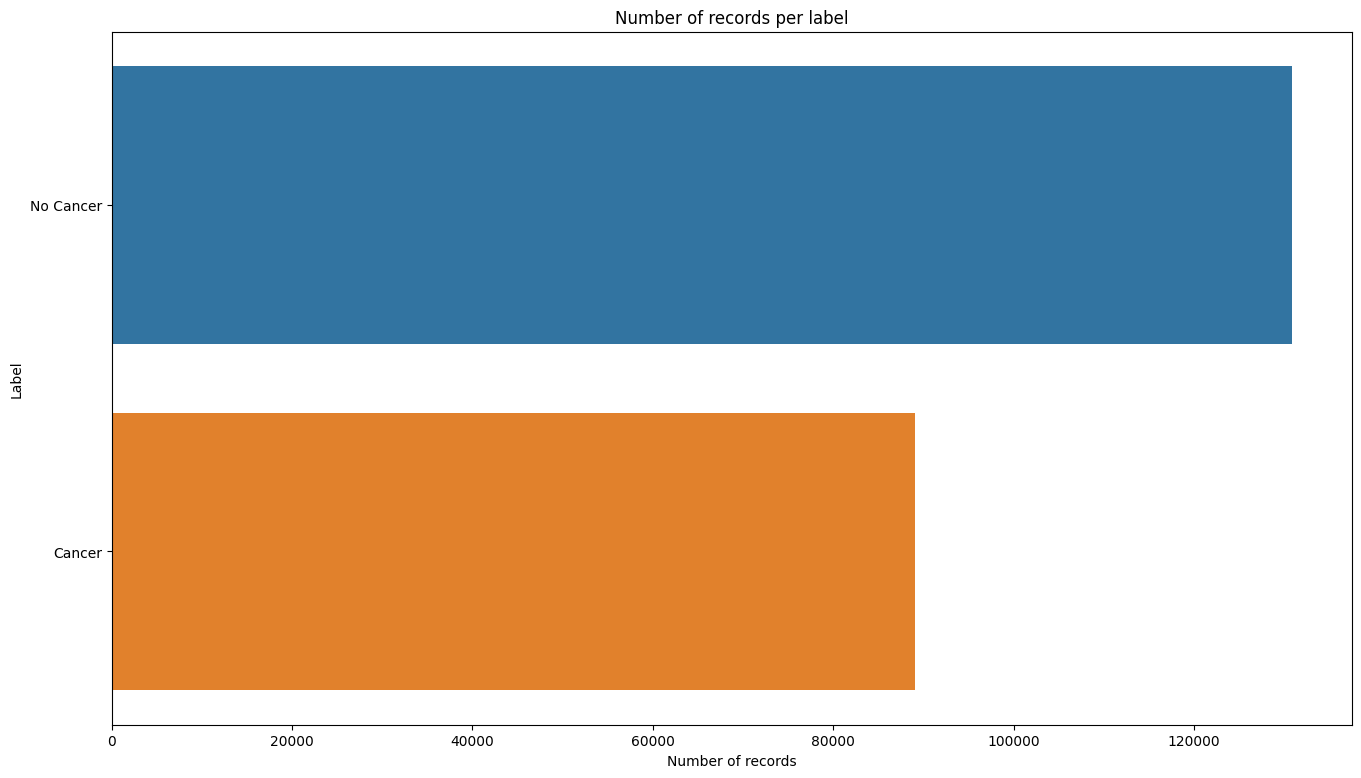

In [9]:
# Plot horizontal barplot of number of records per label
plt.figure(figsize=(16, 9))
tmp = train_data['label'].value_counts()
sns.barplot(y=['No Cancer', 'Cancer'], x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Label')
plt.title('Number of records per label')
plt.show()

## 4.3 Images <a class="anchor" id="images"></a>

In [10]:
def get_images_to_plot(file_names):
    """
    Returns list of images
    Args:
        file_names: list of filenames
    Returns:
        list of image objects
    """
    return [Image.open(f) for f in file_names]

def get_image_label(dirname, data, labels, n = 5):
    dict_img = {}
    for l in labels:
        indexes = data['label'] == l
        tmp = data[indexes][:n]
        tmp = dirname + tmp['id'] + '.tif'
        tmp = tmp.values
        tmp = get_images_to_plot(tmp)
        dict_img[l] = tmp
        
    return dict_img

In [11]:
# Print original image size
img_path = train_dir + train_data['id'][0] + '.tif'
img = Image.open(img_path)
print('Original image size: {}'.format(img.size))

Original image size: (96, 96)


In [12]:
# Get 5 filenames per label
data = get_image_label(train_dir,train_data, [0,1])

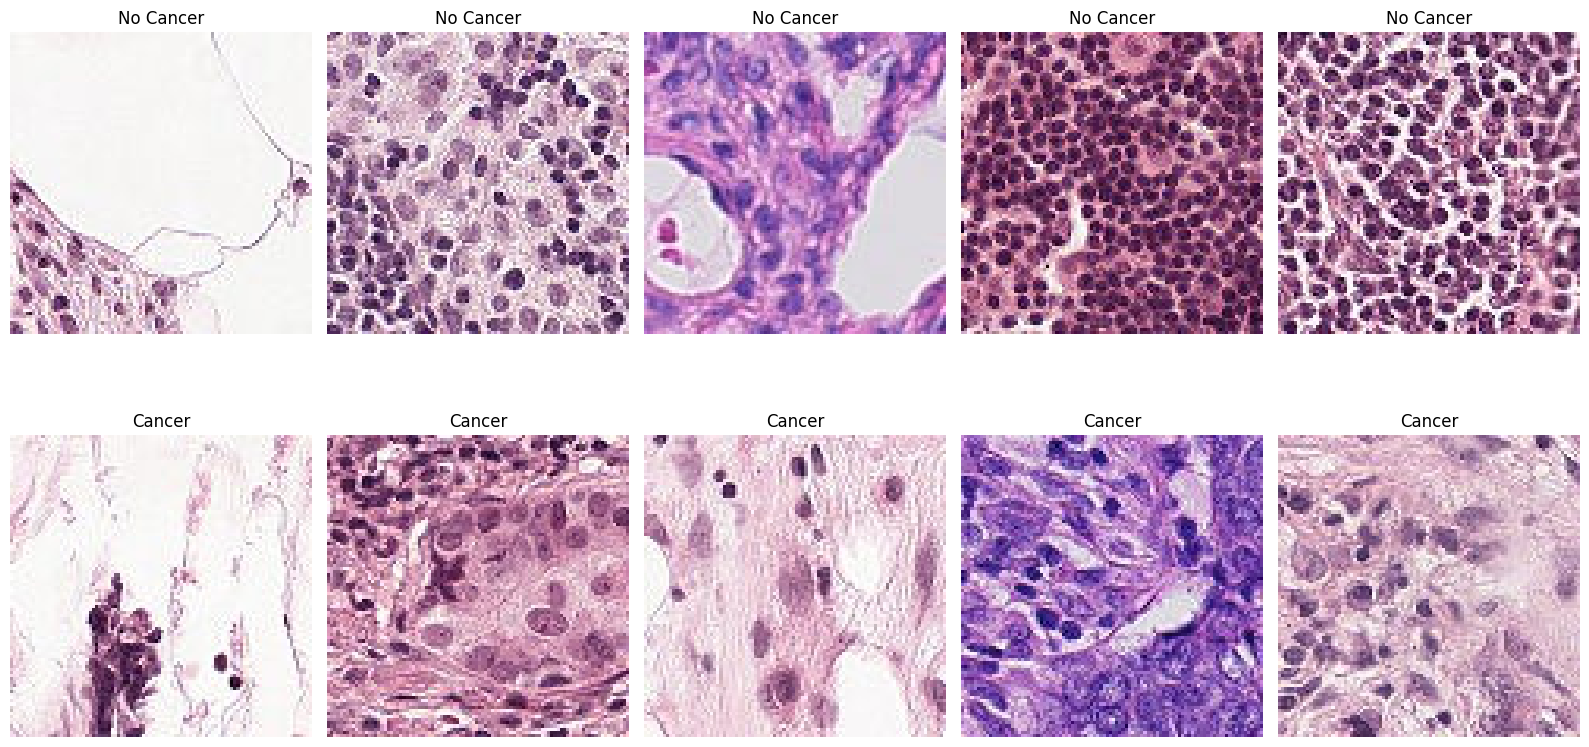

In [13]:
# Initialize subplots with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))

# Loop through the selected images and display in the respective rows
labels = ['No Cancer', 'Cancer']
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(data[row][col])
    axes[row, col].set_title(labels[row])
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 5. Data preprocessing <a class="anchor" id="data_preprocessing"></a>

## 5.1 Sampling <a class="anchor" id="sampling"></a>

Downsampling or upsampling are about bias-variance trade-off. In the first one we reduce the number of records from the majority class. In the second one we replicate existing instances of minority class. In both cases we're trying to even number of labels to:
* mitigate error of calculating ROC AUC score if there is only one label present in the selected set
* improve model performance, be it better generalization (upsample) or faster training (downsample)

In our case the choice falls in favor of downsampling. Since we're dealing with basic CNN comparison and not aiming for the top performance algorithm, we are limited by the default computational power, including accelerators like GPU T4 x2, GPU P100 or TPU VM. Thus we need to tune not just the models but the training data as well in order to reduce computational time as much as possible. Of course, all of that has to be done without significant loss in the ROC AUC score.




In [25]:
# Majority class
no_cancer = train_data[train_data['label'] == 0]
# Minority class
cancer = train_data[train_data['label'] == 1]
cancer = cancer[:int(0.2*len(cancer))]

# Downsample majority class to match minority class
no_cancer_downsampled = resample(no_cancer,
                              replace=False, 
                              n_samples=len(cancer),
                              random_state=0)

balanced_train_data = pd.concat([no_cancer_downsampled, cancer])

# Shuffle train data for training
balanced_train_data = balanced_train_data.sample(frac=1, random_state=0).reset_index(drop=True)


## 5.2 Train-test split <a class="anchor" id="train_test_split"></a>

Since we're not going to rely on cross validation, we need to provide both train and test samples to CNN to measure overfitting during training. Thus we first split our train dataset into 75% and 25% of train and test data respectively based on the default values of function.

In [26]:
# Get full path to image including extension
image_paths = train_dir + balanced_train_data['id'] + '.tif'
image_paths = image_paths.values

labels = balanced_train_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(image_paths
                                                    , labels
                                                    , test_size = 0.25
                                                    , shuffle = True
                                                    , random_state = 0)

## 5.3 Parallel preprocessing <a class="anchor" id="parallel_preprocessing"></a>

If we were to load images sequentially one-by-one or in batches, we would lose significant amount of time. Therefore it's more efficient to run this process in parallel, so that most of the time would be spent on actual training. With that in mind we're going to incorporate Tensorflow parallel processing functions to use optimal number of CPU cores provided in this notebook.

Additional important measures to increase training speed are the image resolution reduction and pixel scaling.<br/>Given our dataset of 96x96px images we can shrink them to 32x32px. It's an arbitrary reduction found across other kernels on Kaggle, but it helps in our case of speed-score trade-off.<br/>
The justification for pixel scaling lies in the idea of preventing gradients from becoming too large (exploding gradients) or too small (vanishing gradients) during backpropagation. Having this kind of constraint in the gradient values improve model performance overall.

In [17]:
def get_decoded_image(image_path, label=None):
    """
    Load and preprocess images using TensorFlow I/O.
    Decode image with 4 channels RGBA.
    Resize image to 32x32px.
    Scale pixels from 0 to 1.
    Args:
        image_path: path to TIFF image
        label (optional): true label from train data
    Returns:
        (img, label): for train data
        img: for test data
    """
    img = tf.io.read_file(image_path)
    img = tfio.experimental.image.decode_tiff(img)
    img = tf.image.resize(img, [32, 32])
    img = tf.cast(img, tf.float32) / 255.0
    
    return img if label is None else (img, label)

def get_prefetched_data(data, batch_size, buffer_size):
    """
    Create a TensorFlow dataset from image paths and labels.
    Execution in parallel.
    Load, preprocess images, shuffle and batch the data.
    Prefetch batches to improve training performance.
    Args:
        data (tuple): image paths and corresponding labels
        batch_size (int): number of samples per batch
        buffer_size (int): number of elements from the dataset to buffer while shuffling
    Returns:
        tf.data.Dataset: preprocessed and preloaded TensorFlow dataset for keras CNN
    """
    # Autotune the degree of parallelism during training
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    # Create dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Apply parallel processing to load and preprocess images
    dataset = dataset.map(get_decoded_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [27]:
# Get train and test datasets for optimal performance
batch_size = 64
train_buffer_size = X_train.shape[0]
test_buffer_size = X_test.shape[0]

train_dataset = get_prefetched_data((X_train, y_train)
                                    , batch_size
                                    , train_buffer_size)
test_dataset = get_prefetched_data((X_test, y_test)
                                   , batch_size
                                   , test_buffer_size)

# 6. Model architecture <a class="anchor" id="model_architecture"></a>

In [19]:
def roc_auc_score_(y_true, y_pred):
    """
    Calculate ROC AUC score using sklearn built-in function.
    Used in a model.compile as a custom metric.
    Args:
        y_true: true labels
        y_pred: predicted labels
    Returns:
        ROC AUC score (float)
    """
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.float64)

## 6.1 Base model <a class="anchor" id="base_model"></a>

Our base model is going to be simple CNN yet with several layers. All the parameters are based either on the default values of a model, common values among other works or dataset features.
It is going to be comprised of:

1. **Convolutional Layer:**<br/>
It's said that Conv2D layer can capture spatial patterns in the input data. Ours is going to be with 32 filters of size (3, 3). The input shape (32, 32, 4) is used to address 32x32px images with 4 channels RGBA which were preprocessed by tfio.experimental.image.decode_tiff().
2. **Pooling Layer:**<br/>
The MaxPooling2D layer focuses on the most important features. Our setup is the window size of (2,2) and the stride of (2,2) which are the default values. With that we reduce the spatial dimensions of the feature map by half in both width and height.
3. **Flatten Layer:**<br/>
The Flatten layer transforms the 2D feature maps into a 1D vector, preparing the data for the subsequent dense layers.
4. **Dense Layers:**<br/>
The first Dense layer with 64 units and the ReLU activation function enables the model to learn intricate relationships in the data. The final Dense layer with 1 unit and the sigmoid activation function is to output probability of having cancer in the image.
7. **Activations:**<br/>
* ReLU: introduces non-linearity into the model by replacing all negative values in the input with zero and supposedly computationally efficient<br/>
* Sigmoid: within the range between 0 and 1 it represents the probability of belonging to the positive class, which is useful in our binary class problem

6. **Loss Function and Optimizer:**<br/>
* binary_crossentropy loss: forces the model to output probabilities close to 1 for cancer instances and close to 0 otherwise<br/>
* adam optimizer: efficient and common optimization algorithm


In [20]:
# Define base CNN
model_base = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

## 6.2 Dropout and batch normalization <a class="anchor" id="dropout_batch_normalization"></a>

To tackle the problem of overfitting, we can add additional layer of Dropout Regularization. Dropout randomly sets a fraction of input units to 0 during training, which prevents model over adjusting its weights to train data. We're going to arbitrary set the dropout rate to 0.25, indicating that during training, 25% of the input units will be dropped out (set to 0).

To help solve another issue, slow training speed, we can add a layer of Batch Normalization. And thus normalize the activations of a layer, making the optimization more efficient.

In [21]:
# Define CNN with dropout and batch normalization layers
model_drop_bn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 4))
    , layers.BatchNormalization()
    , layers.MaxPooling2D((2, 2))
    , layers.Flatten()
    , layers.Dense(64, activation='relu')
    , layers.Dropout(0.25)
    , layers.Dense(1, activation='sigmoid')
])

## 6.3 Tuned hyperparameters <a class="anchor" id="tuned_hyperparameters"></a>

In this section we're going to tune several hyperparameters based on the previous network architecture. Concretely:
1. **Number of filters in the Conv2D layer:**<br/>
Increasing the number of filters can allow the model to capture more complex patterns in the data. We're going to double the amount from 32 to 64.
2. **MaxPooling2d stride scale:**<br/>
Smaller stride presents a trade-off of more details for increased computation, while larger stride offers the opposite. We're going to increase stride from (2,2) to (4,4) for higher computational speed.
3. **Dropout rate:**<br/>
The higher dropout rate the lower chances of overfitting. We're going to increase rate from 0.25 to 0.35.


In [22]:
# Define CNN with tuned hyperparameters
model_tuned = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 4))
    , layers.BatchNormalization()
    , layers.MaxPooling2D((4, 4))
    , layers.Flatten()
    , layers.Dense(64, activation='relu')
    , layers.Dropout(0.35)
    , layers.Dense(1, activation='sigmoid')
])

# 7. Model results comparison <a class="anchor" id="model_results_comparison"></a>

In [37]:
def plot_model_scores(scores):
    """
    Plot train and test ROC AUC scores of a model by epoch
    """
    train_scores, test_scores = scores
    epochs = range(1, len(train_scores) + 1)

    # Plot train and test scores
    plt.figure(figsize=(16, 9))
    plt.plot(epochs, train_scores, 'b', label='Train score')
    plt.plot(epochs, test_scores, 'r', label='Test score')
    plt.title('Train and test ROC AUC scores')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_model_results(model_name, model):
    """
    Return tuple of runtime, train and test scores.
    Compile, fit and save model along the way.
    Args:
        model_name: model name
        model: fitted model
    Returns:
        (runtime, (train_scores, test_scores) )
    """
    st = time.time()
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[roc_auc_score_])
    model.fit(train_dataset, epochs=5, validation_data=test_dataset)
    runtime = time.time() - st
    model.save('{}.h5'.format(model_name))
    train_scores = model.history.history['roc_auc_score_']
    test_scores = model.history.history['val_roc_auc_score_']
    del model
    
    return (runtime, (train_scores, test_scores))

## 7.1 Base model results <a class="anchor" id="base_model_results"></a>

In [38]:
# Get train and test scores of every epoch
runtime_base, scores_base = get_model_results('base', model_base)

Epoch 1/5
418/418 [==============================] - 40s 42ms/step - loss: 0.3688 - roc_auc_score_: 0.9235 - val_loss: 0.4233 - val_roc_auc_score_: 0.8980
Epoch 2/5
418/418 [==============================] - 34s 38ms/step - loss: 0.3576 - roc_auc_score_: 0.9283 - val_loss: 0.4085 - val_roc_auc_score_: 0.8961
Epoch 3/5
418/418 [==============================] - 43s 42ms/step - loss: 0.3504 - roc_auc_score_: 0.9324 - val_loss: 0.4338 - val_roc_auc_score_: 0.8908
Epoch 4/5
418/418 [==============================] - 38s 40ms/step - loss: 0.3362 - roc_auc_score_: 0.9378 - val_loss: 0.4270 - val_roc_auc_score_: 0.8915
Epoch 5/5
418/418 [==============================] - 34s 36ms/step - loss: 0.3227 - roc_auc_score_: 0.9406 - val_loss: 0.4380 - val_roc_auc_score_: 0.8847


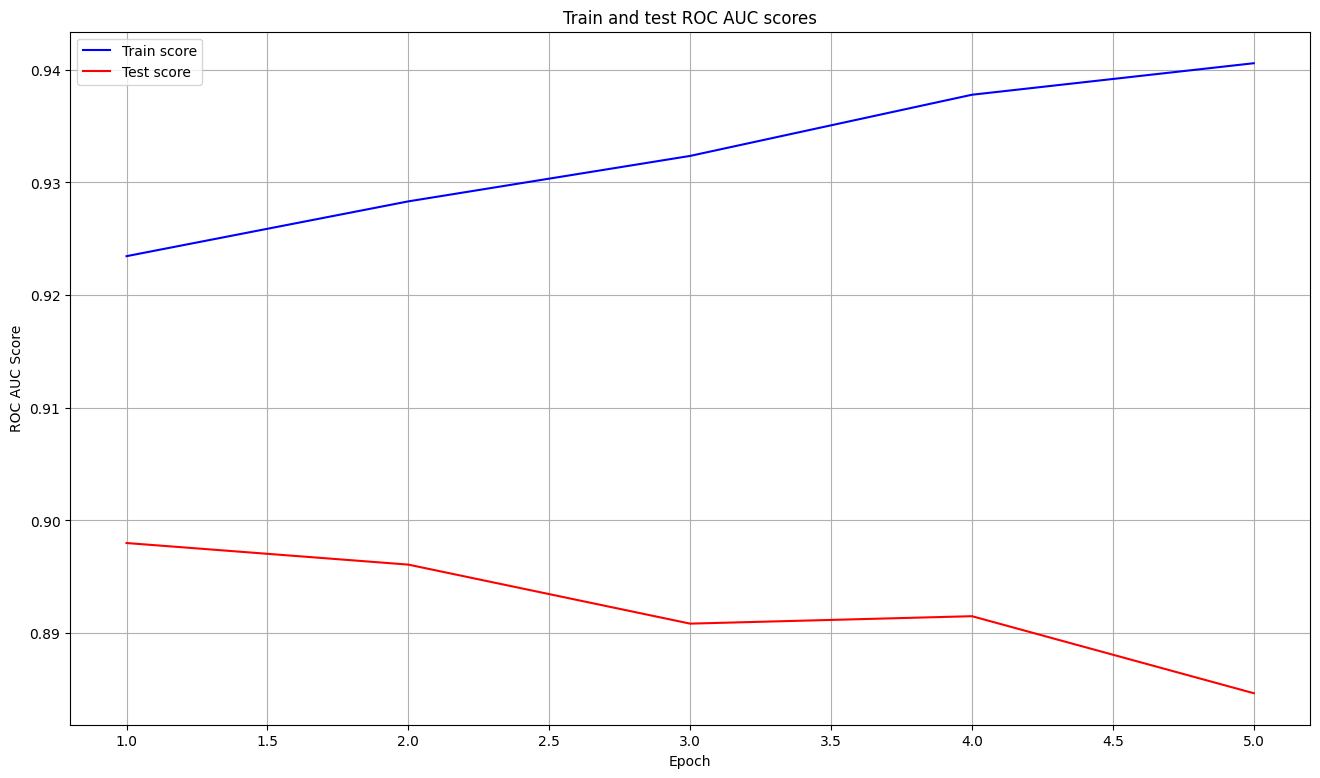

In [39]:
# Plot scores
plot_model_scores(scores_base)

## 7.2 Dropout and batch normalization results <a class="anchor" id="dropout_batch_normalization_results"></a>

In [ ]:
# Get train and test scores of every epoch
runtime_drop_bn, scores_drop_bn = get_model_results('drop_bn', model_drop_bn)

In [ ]:
# Plot scores
plot_model_scores(scores_drop_norm)

## 7.3 Tuned hyperparameters results <a class="anchor" id="tuned_hyperparameters_results"></a>

In [ ]:
# Get train and test scores of every epoch
runtime_tuned, scores_tuned = get_model_results('tuned', model_tuned)

In [ ]:
# Plot scores
plot_model_scores(scores_tuned)

## 7.4 Table results comparison <a class="anchor" id="table_results_comparison"></a>

In [ ]:
table = [
    {
        'model':'Base'
        , 'runtime': runtime_base
        , 'train_roc_auc_score': scores_base[0][-1]
        , 'test_roc_auc_score': scores_base[1][-1]
    }
    ,{
        'model':'Drop and BN'
        , 'runtime': runtime_drop_bn
        , 'train_roc_auc_score': scores_drop_bn[0][-1]
        , 'test_roc_auc_score': scores_drop_bn[1][-1]
    }
    ,{
        'model':'Tuned'
        , 'runtime': runtime_tuned
        , 'train_roc_auc_score': scores_tuned[0][-1]
        , 'test_roc_auc_score': scores_tuned[1][-1]
    }
]

pd.DataFrame(table).sort_values(by = ['test_roc_auc_score','runtime']
                                , ascending = [False, True])

# 8. Submission Results <a class="anchor" id="submission_results"></a>

# 9. Conclusion <a class="anchor" id="conclusion"></a>

Short analysis of results. Possible explanation. Use in production.

# 10. References <a class="anchor" id="references"></a>

List of links to kernels and articles.